## Introduction to gridding
A common activity for working with scanning radar data is the estimation of the radar measuremets (and retrievals) on a regularly spaced grid. This could be for GIS purposes, the compraring to other data sources or for comparisons to model outputs. 

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pyart
import os
import cartopy.crs as ccrs




## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
#Lets read in our data set
radar = pyart.io.read(os.path.expanduser('~/data/arm/csapr_test_case.nc'), 
                      delay_field_loading = True)


## Lets get some basic geometry about our radar data

In [4]:
max_lat = radar.gate_latitude['data'].max()
min_lat = radar.gate_latitude['data'].min()
max_lon = radar.gate_longitude['data'].max()
min_lon = radar.gate_longitude['data'].min()
print(max_lat, min_lat, max_lon, min_lon)

height = radar.gate_altitude
lats = radar.gate_latitude
lons = radar.gate_longitude
lat_lines = np.arange(min_lat, max_lat, .5)
lon_lines = np.arange(min_lon, max_lon, .5)


37.854942 35.737362 -96.12828 -98.7728


## Lets take a look at all the bells and whistles on Py-ART's Gridder

In [5]:
pyart.map.map_gates_to_grid?

## Lets make a regular grid 
31 vertical levels, 301 by 301 horizontal points. 0 to 15km in height, and -120 to 120km in x and y. 

In [6]:
grids = pyart.map.grid_from_radars(radar,(31,301,301),
                   ((0.,15000.),(-120000.,120000.),(-120000.,120000.)),
                   refl_field='reflectivity', weighting_function='Barnes2')

# So what did we get???

In [11]:
grids?

In [13]:
grids.fields.keys()

dict_keys(['vertical_reflectivity', 'specific_differential_phase', 'differential_reflectivity', 'reflectivity', 'normalized_coherent_power', 'differential_phase', 'copolar_correlation_coefficient', 'velocity', 'spectrum_width', 'ROI'])

## Why your own grid object? What about xarray?
When Py-ART was being developed xarray was very new.. but fear not! We have a simple method for converting

In [14]:
grids.to_xarray?

In [7]:
xgrids = grids.to_xarray()

In [8]:
xgrids

<xarray.Dataset>
Dimensions:                          (time: 1, x: 301, y: 301, z: 31)
Coordinates:
  * time                             (time) object 2015-07-09 13:45:22.911155
  * z                                (z) float64 0.0 500.0 ... 1.45e+04 1.5e+04
    lat                              (y) float64 35.71 35.72 ... 37.86 37.87
    lon                              (x) float64 -98.78 -98.77 ... -96.13 -96.12
  * y                                (y) float64 -1.2e+05 -1.192e+05 ... 1.2e+05
  * x                                (x) float64 -1.2e+05 -1.192e+05 ... 1.2e+05
Data variables:
    vertical_reflectivity            (time, z, y, x) float32 nan nan ... nan nan
    copolar_correlation_coefficient  (time, z, y, x) float32 nan nan ... nan nan
    specific_differential_phase      (time, z, y, x) float32 nan nan ... nan nan
    reflectivity                     (time, z, y, x) float32 nan nan ... nan nan
    normalized_coherent_power        (time, z, y, x) float32 nan nan ... nan nan
    velocity                         (time, z, y, x) float32 nan nan ... nan nan
    differential_reflectivity        (time, z, y, x) float32 nan nan ... nan nan
    differential_phase               (time, z, y, x) float32 nan nan ... nan nan
    spectrum_width                   (time, z, y, x) float32 nan nan ... nan nan
    ROI                              (time, z, y, x) float32 4.444e+03 ... 5....

In [9]:
xgrids.reflectivity.mean()

<xarray.DataArray 'reflectivity' ()>
array(5.0342607, dtype=float32)

In [17]:
xgrids.reflectivity.sel(z=500, time=xgrids.time[0])

<xarray.DataArray 'reflectivity' (y: 301, x: 301)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     object 2015-07-09 13:45:22.911155
    z        float64 500.0
    lat      (y) float64 35.71 35.72 35.72 35.73 ... 37.85 37.85 37.86 37.87
    lon      (x) float64 -98.78 -98.77 -98.76 -98.75 ... -96.14 -96.13 -96.12
  * y        (y) float64 -1.2e+05 -1.192e+05 -1.184e+05 ... 1.192e+05 1.2e+05
  * x        (x) float64 -1.2e+05 -1.192e+05 -1.184e+05 ... 1.192e+05 1.2e+05
Attributes:
    long_name:             Horizontal co-polar reflectivity
    units:                 dBZ
    _FillValue:            -32768.0
    threshold_value:       -9999.0
    grid_mapping:          grid_mapping
    sampling_ratio:        1.0
    coordinates:           time range
    standard_name:         equivalent_reflectivity_factor
    threshold_field_name:

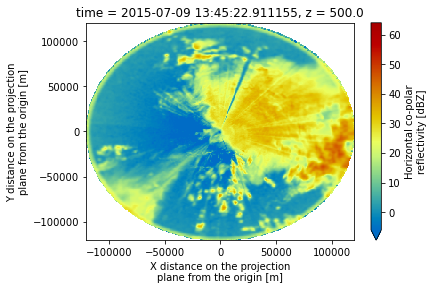

In [18]:
xgrids.reflectivity.sel(z=500, time=xgrids.time[0]).plot.pcolormesh(cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin=-6, vmax=64)

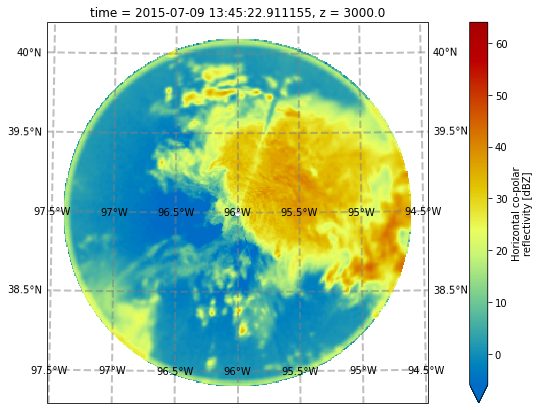

In [28]:
fig = plt.figure(figsize=[15, 7])
ax = plt.axes(projection=ccrs.LambertConformal())
pc = xgrids.reflectivity.sel(z=3000, 
                        time=xgrids.time[0]).plot.pcolormesh(cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                                                             vmin=-6, vmax=64)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

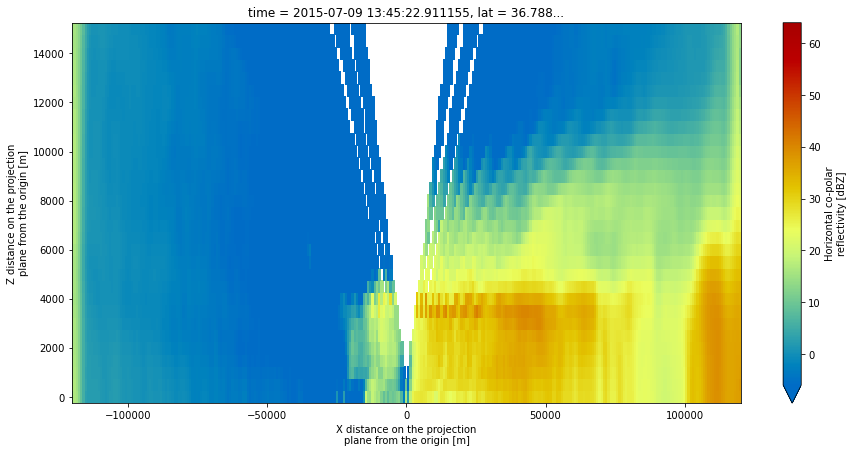

In [35]:
fig = plt.figure(figsize=[15, 7])
pc = xgrids.reflectivity.sel(y=0, time=xgrids.time[0]).plot.pcolormesh(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                                                                      vmin=-6, vmax=64)



/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/pyart/graph/gridmapdisplay.py:844: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.get_path().vertices.tolist())
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/pyart/graph/gridmapdisplay.py:844: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.get_path().vertices.tolist())


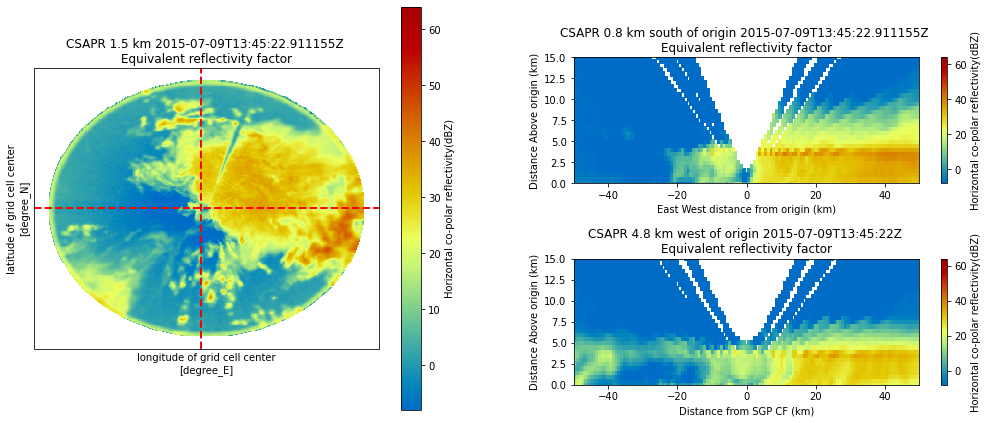

In [36]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# parameters
level = 3
vmin = -8
vmax = 64
lat = 36.79
lon = -97.5

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes, projection=ccrs.LambertConformal() )
#display.plot_grid(lon_lines = lon_lines, resolution='l' )
display.plot_grid('reflectivity', level=level, vmin=vmin, vmax=vmax)
display.plot_crosshairs(lon=lon, lat=lat)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax)
ax2.set_ylim([0,15])
ax2.set_xlim([-50,50])
ax2.set_xlabel('Distance from SGP CF (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0,15])
ax3.set_xlim([-50,50])
display.plot_latitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax)